## Predicting the country from addiliation address

This notebook reads in a csv file with information about mexican scientific intitutions in string-form:

    Author_ID    Address_Full    City    Institution_Full   State

If the state is given for a specific row, this row will be used as training- or test-data. If it is missing, the model will predict the state and save it in the column ```predicted```

#### How?

1. read the authorship-records from a csv-file into a pandas dataframe
2. merge the columns ("'CITY', 'INSTITUTION_FULL','ADDRESS_FULL'") to create a single input-string
3. analyze the frequency of every word in the whole dataset
4. choose the 3000 most frequent words and use them as input vektor for a feed-forward neural network
5. for every row: create the input vektor from the words in the input-string
6. create the neural network (a quite standard network with 4 layers)
7. train the network with 80 % of the input data
8. predict the 20 % test data and compare the predictions to the given states -->
9. predict the (~6%) missing values for states
10. do some plotting...

In [2]:
# modify the wrong country code 

def substitue(x):
    if (x=="YUG") | (x=="YUX"): 
        x="SRB"
    elif (x=="ROM"):
        x="ROU"
    elif (x=="ANT"):
        x="NLD"
    elif (x=="DDR"):
        x="DEU"
    elif (x=="UMI"):
        x="USA"
    else:
        pass
    
    return x

#all_records["COUNTRYCODE"]=all_records["COUNTRYCODE"].map(lambda x: substitue(x))

In [1]:
import pandas as pd
import numpy as np
import pickle
from pathlib import Path
import matplotlib.pyplot as plt

print("\n           -------------start-------------")
# For reproducibility
np.random.seed(12375)
 

#User-input/ parameters
path_data = "N:\\Bibliometric_Germany\\KB data\\processed\\new_2021_Feb\\"  # Source file directory
# Filename of the dataset
fn_train = "0_train_country6.csv" #"train_country5.csv" #"df_shuffled.csv"  #"scopus_neuralnetwork_subset_ansi.csv" #"train4-womexico.csv" #"train3.csv" #"filewos_bib_random_nastates.csv"
cnState = "COUNTRYCODE" # "d_state"  # Column name for the state/label-column
encoding ='utf-8'
nrowstoread = 200000000 #
shuffleRows = True # if the dataset is not already shuffled, it needs to be shuffled to get good results
saveDataset = False
dropRowIfStateNa = True

usecols=['CITY', 'INSTITUTION_FULL',"AUTHOR_ID","PUBYEAR",cnState]
dtypes = {"AUTHOR_ID":"object"}


           -------------start-------------


In [2]:
df = pd.read_csv(path_data + fn_train, usecols=usecols, dtype=dtypes, encoding=encoding,nrows=nrowstoread) #,na_values=["noInput"]) #,'OBSERVATION' #


if dropRowIfStateNa:
    print("drop rows without state")
    df = df.dropna(subset=[cnState]) # delete row if "Na" in cnState-Column https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.dropna.html


#merge the input-columns into one big string column 'merged'
df["merged"] = df["CITY"].map(str) + ' ' + df["INSTITUTION_FULL"] 

df["merged"] = df["merged"].fillna('noInput') # spent 3 hours to find a bug that was caused by na-input in the merged-column...


print(df.head(3))
# df.to_csv('merged.csv')

if shuffleRows:
    df = df.reindex(np.random.permutation(df.index)) # shuffle the rows, because I suspect some row-dependence... undo for debugging

if saveDataset:
    df.to_csv('df_shuffled.csv', columns=[cnState,"CITY","INSTITUTION_FULL","AUTHOR_ID","PUBYEAR"],encoding=encoding)
    df.to_csv('df_shuffled_merged.csv', columns=[cnState,"merged","AUTHOR_ID","PUBYEAR"],encoding=encoding)

drop rows without state
     AUTHOR_ID  PUBYEAR                          INSTITUTION_FULL  CITY  \
0  57213210210   2017.0  Institute of Sport and Exercise Sciences   NaN   
1   7004571674   2001.0                       Augenklinik der LMU   NaN   
2  35226955000   2015.0                      INFN Sezione di Pisa  Pisa   

  COUNTRYCODE                                        merged  
0         GBR  nan Institute of Sport and Exercise Sciences  
1         DEU                       nan Augenklinik der LMU  
2         ITA                     Pisa INFN Sezione di Pisa  


In [3]:
df

,AUTHOR_ID,PUBYEAR,INSTITUTION_FULL,CITY,COUNTRYCODE,merged
391208,36640738500,2019.0,European Organization for Nuclear Research (CERN),Geneva,CHE,Geneva European Organization for Nuclear Resea...
721616,36607254800,2010.0,Lehrbeauftragter An der Hochschule für Technik...,NaN,DEU,nan Lehrbeauftragter An der Hochschule für Tec...
132274,35227994300,2014.0,Georg-August-UniversitätII Physikalisches Inst...,Göttingen,DEU,Göttingen Georg-August-UniversitätII Physikali...
361148,55147588300,2017.0,Institute of Product Development and Mechanica...,NaN,DEU,nan Institute of Product Development and Mecha...
465941,35285610600,2011.0,Università del Piemonte Orientale (Novara),Torino,ITA,Torino Università del Piemonte Orientale (Novara)
...,...,...,...,...,...,...
256599,9433360100,2016.0,Technical University of Denmark,Copenhagen,DNK,Copenhagen Technical University of Denmark
194155,56216355500,1998.0,Universitatskrankenhaus E.Inst. Zellbiochemie ...,NaN,DEU,nan Universitatskrankenhaus E.Inst. Zellbioche...
299260,35248772300,2007.0,University Hospital Zürich,NaN,CHE,nan University Hospital Zürich
507480,55413905700,2012.0,Hamburg University of TechnologyInstitute of P...,NaN,DEU,nan Hamburg University of TechnologyInstitute ...


In [4]:
# Normalize the merged column (e.g. replacing ú with u)
df["merged"] = df["merged"].str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')
df["merged"] = df["merged"].fillna('noInput')

In [7]:
df.head(200)

,PUBYEAR,AUTHOR_ID,INSTITUTION_FULL,CITY,COUNTRYCODE,merged
96903,2019,6603218977,"Hospital for Special Surgery, Department of Or...",New York,USA,"New York Hospital for Special Surgery, Departm..."
79729,2019,57203133853,"University of Cologne, Center for Molecular Me...",Cologne,DEU,"Cologne University of Cologne, Center for Mole..."
63233,2019,7004713188,"Climate Research Programme, Finnish Meteorolog...",Helsinki,FIN,"Helsinki Climate Research Programme, Finnish M..."
79911,2019,55627275500,"University Hospital Würzburg, Comprehensive Ca...",Würzburg,DEU,"Wurzburg University Hospital Wurzburg, Compreh..."
97991,2019,56520264000,Leibniz Institute for Plasma Science and Techn...,Greifswald,DEU,Greifswald Leibniz Institute for Plasma Scienc...
...,...,...,...,...,...,...
69143,2019,13607797300,"National University of Singapore, Department o...",NaN,SGP,"nan National University of Singapore, Departme..."
39084,2020,36891528600,"LMU Munich, Walter Brendel Center of Experimen...",Munich,DEU,"Munich LMU Munich, Walter Brendel Center of Ex..."
67371,2019,7103406164,"University of Birmingham, Institute of Immunol...",Birmingham,GBR,"Birmingham University of Birmingham, Institute..."
23696,2020,7004926264,"Policlinico Umberto I, “Sapienza” University, ...",Rome,ITA,"Rome Policlinico Umberto I, Sapienza Universit..."


#### using Keras for training and predicting

In [5]:
# prepare data for keras:
# lets take 80% data as training and remaining 20% for test.
train_size = int(len(df) * 0.8) # 0.8....
 
train_input = df['merged'][:train_size]
train_tags = df[cnState][:train_size]
#train_files_names = df['filename'][:train_size]
 
test_input = df['merged'][train_size:]
test_tags = df[cnState][train_size:]
#test_files_names = dtrainingata['filename'][train_size:]


# 32 states and NA
n_unique = df[cnState].nunique() # number of different states
print("nunique: ", df[cnState].nunique())
print("unique States: ", df[cnState].unique())
num_labels = n_unique #26   # there are only 25 states with institiutions in the dataset
vocab_size = 3000  # how many different words to keep?
batch_size = 80 # doesnt matter
 

nunique:  182
unique States:  ['CHE' 'DEU' 'ITA' 'DNK' 'NLD' 'RUS' 'ESP' 'FRA' 'USA' 'CHN' 'FIN' 'JPN'
 'GBR' 'BRA' 'IND' 'AUT' 'PRT' 'IRL' 'NGA' 'CZE' 'PAK' 'AUS' 'HUN' 'ZAF'
 'BEL' 'ARG' 'GRC' 'SWE' 'CAN' 'UKR' 'KOR' 'POL' 'MAR' 'ISR' 'ROU' 'NZL'
 'PER' 'MEX' 'TWN' 'CHL' 'SAU' 'SVK' 'ISL' 'LVA' 'TUR' 'NOR' 'BGR' 'LTU'
 'DZA' 'SVN' 'CMR' 'VNM' 'BIH' 'ARE' 'HKG' 'MDA' 'SGP' 'EST' 'BLR' 'GEO'
 'SYR' 'LBN' 'EGY' 'IRN' 'TUN' 'IDN' 'BEN' 'MYS' 'LUX' 'TZA' 'HRV' 'COL'
 'OMN' 'PRI' 'GTM' 'KAZ' 'ZWE' 'CIV' 'COD' 'SRB' 'MKD' 'ARM' 'ECU' 'ETH'
 'CYP' 'THA' 'PAN' 'KEN' 'KWT' 'GMB' 'AZE' 'UGA' 'MNG' 'CUB' 'BGD' 'SLV'
 'MDG' 'FRO' 'LIE' 'URY' 'BOL' 'ATA' 'JOR' 'LAO' 'GAB' 'LBY' 'CRI' 'QAT'
 'NPL' 'MCO' 'PSE' 'MLI' 'NCL' 'GHA' 'SLE' 'BFA' 'UZB' 'KHM' 'SOM' 'MNE'
 'PHL' 'MWI' 'NAM' 'COG' 'VEN' 'BRN' 'IRQ' 'BWA' 'PRY' 'GRD' 'RWA' 'MAC'
 'MOZ' 'LKA' 'MLT' 'SUR' 'JAM' 'TGO' 'TTO' 'DOM' 'TCD' 'NIC' 'SEN' 'BHR'
 'SCG' 'SDN' 'AFG' 'NER' 'TJK' 'KGZ' 'BMU' 'ALB' 'GUF' 'SYC' 'MMR' 'BRB'
 'FJI' 'SUX' 'PNG' 'Y

In [6]:
#import keras and everything we need from keras
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Conv1D, MaxPooling1D,GlobalMaxPool1D
from keras.constraints import maxnorm
from keras.utils import plot_model, to_categorical


#import sci-kit...
from sklearn.preprocessing import LabelBinarizer
import sklearn.datasets as skds


Using TensorFlow backend.


In [7]:
train_input.head(56).values

array(['Geneva European Organization for Nuclear Research (CERN)',
       'nan Lehrbeauftragter An der Hochschule fur Technik Zurich',
       'Gottingen Georg-August-UniversitatII Physikalisches Institut',
       'nan Institute of Product Development and Mechanical Engineering DesignHamburg University of Technology',
       'Torino Universita del Piemonte Orientale (Novara)',
       'nan Center of International, Management and Innovation, University of Hohenheim',
       'Bonn Max Planck Institute for Radio Astronomy',
       'nan Institute for Metallic MaterialsIFW Dresden',
       'nan University of CopenhagenDepartment of Chemistry',
       'nan Multitrophic Interactions DepartmentCentre for Terrestrial EcologyNetherlands Institute of Ecology',
       'Moscow M.V. Lomonosov Moscow State UniversityD.V. Skobeltsyn Institute of Nuclear Physics',
       'Hamburg and Zeuthen Deutsches Elektronen-Synchrotron DESY',
       'nan University Hospital MaastrichtDepartment of Urology',
       '

In [8]:
%%time

# define Tokenizer with Vocab Size
# This analyzes the most frequent words in the input-data
tokenizer = Tokenizer(num_words=vocab_size)

tokenizer.fit_on_texts(train_input)
 
x_train = tokenizer.texts_to_matrix(train_input, mode='tfidf')
print(x_train[0])
print(f"x_Train.len:{len(x_train[0])}")
x_test = tokenizer.texts_to_matrix(test_input, mode='tfidf')
 

[0. 0. 0. ... 0. 0. 0.]
x_Train.len:3000
Wall time: 1min 27s


In [9]:
# create the input vectors for every row
encoder = LabelBinarizer()
encoder.fit(train_tags)
y_train = encoder.transform(train_tags)
y_test = encoder.transform(test_tags)


#print("train tags_ ", train_tags[0:20])
#y_train = to_categorical(train_tags, num_labels)
#y_test = to_categorical(test_tags, num_labels)

text_labels = encoder.classes_

print("y_train: ", y_train[0:10])
for ls in range(10):
    print("y_train argmax",(np.argmax(y_train[ls])))
print("y_test",  y_test[0:10])
print("labels: ", text_labels)
#exit()

y_train:  [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
y_train argmax 28
y_train argmax 41
y_train argmax 41
y_train argmax 41
y_train argmax 78
y_train argmax 41
y_train argmax 41
y_train argmax 41
y_train argmax 42
y_train argmax 118
y_test [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
labels:  ['AFG' 'ALB' 'ARE' 'ARG' 'ARM' 'ATA' 'AUS' 'AUT' 'AZE' 'BDI' 'BEL' 'BEN'
 'BFA' 'BGD' 'BGR' 'BHR' 'BHS' 'BIH' 'BLR' 'BMU' 'BOL' 'BRA' 'BRB' 'BRN'
 'BTN' 'BWA' 'CAF' 'CAN' 'CHE' 'CHL' 'CHN' 'CIV' 'CMR' 'COD' 'COG' 'COL'
 'CRI' 'CUB' 'CYM' 'CYP' 'CZE' 'DEU' 'DNK' 'DOM' 'DZA' 'ECU' 'EGY' 'ESP'
 'EST' 'ETH' 'FIN' 'FJI' 'FRA' 'FRO' 'GAB' 'GBR' 'GEO' 'GHA' 'GIN' 'GMB'
 'GRC' 'GRD' 'GRL' 'GTM' 'GUF' 'GUM' 'GUY' 'HKG' 'HND' 'HRV' 'HUN' 'IDN'
 'IND' 'IRL' 'IRN' 'IRQ' 'ISL' 'ISR' 'ITA' 'JAM' 'JOR' 'JPN' 'KAZ' 'KEN'
 'KGZ' 'KHM' 'KOR' 'KWT' 'LAO' 'LBN' 'LBY'

In [10]:
num_labels = len(text_labels)
num_labels

175

In [11]:
# create the Neural-network architecture and train it

print("\n\n ---------- and now the actual keras training: -----------4\n\n")

model = Sequential()
model.add(Dense(int(300), input_shape=(vocab_size,)))
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(Dense(int(80)))
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(Dense(int(50)))
model.add(Activation('relu'))
model.add(Dropout(0.15))
model.add(Dense(num_labels))
model.add(Activation('softmax'))
model.summary()
 
model.compile(loss='mean_squared_error', #'categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
 
    
# Here starts the training:
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=10,
                    verbose=1,
                    validation_split=0.1)
print("training done")



 ---------- and now the actual keras training: -----------4






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 300)               900300    
_________________________________________________________________
activation_1 (Activation)    (None, 300)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 300)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 80)                24080     
_________________________________________________________________
activation_2 (Activation)    (None, 80)                0         
_________________________________________________________________
dropout_2 (Dropout)      

In [12]:
### # Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()
	

C:\ProgramData\Anaconda3\lib\site-packages\dask\dataframe\utils.py:14: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


KeyError: 'accuracy'

In [13]:
print(x_test.shape)
print(y_test.shape)

(200000, 3000)
(200000, 175)


### install GraphViz in Jupyter

1. Graphviz is an open-source python module that is used to create graph objects which can be completed using different nodes and edges. It is based on the DOT language of the Graphviz software and in python it allows us to download the source code of the graph in DOT language

2. PyDotPlus is an improved version of the old pydot project that provides a Python Interface to Graphviz's Dot language.


In [15]:
!pip install GraphViz

In [16]:
import keras
import pydotplus
from keras.utils import plot_model
from keras.utils.vis_utils import model_to_dot
keras.utils.vis_utils.pydot = pydotplus
plot_model(model, show_shapes=True, show_layer_names=True)

ModuleNotFoundError: No module named 'pydotplus'

In [19]:
from IPython.display import SVG
from keras.utils import model_to_dot

SVG(model_to_dot(model).create(prog='dot', format='svg'))

InvocationException: GraphViz's executables not found

In [17]:
# let the model predict the test-data and get the score
# look into the predictions

score = model.evaluate(x_test, y_test,
                       batch_size=batch_size, verbose=1)
 
print('Test accuracy:', score[1])

#plot_model(model, to_file='model.png')

def test_some_samples(x_test,n=100):
    for i in range(n):
        prediction = model.predict(np.array([x_test[i]]))
        predicted_number = np.argmax(prediction[0])
        predicted_label = text_labels[predicted_number]
        #print(test_files_names.iloc[i])
        #print(f"\n {i} input-text: {train_input[i]} " )#+ train_input[i])
        #print(f"x_train {i}: {x_train[i]},\n y_train i: {y_train[i]}")
        print('Label:' + test_tags.iloc[i].ljust(19) + " -Predicted label: "
        + predicted_label.ljust(19) + f" {np.max(prediction[0]):4.2f}")
        #print(prediction)
test_some_samples(x_test,n=10)
print(text_labels)

200000/200000 [==============================] - 1080s 5ms/step
Test accuracy: 0.8942050007581711
Label:GBR                 -Predicted label: NLD                 1.00
Label:BEL                 -Predicted label: BEL                 1.00
Label:AUT                 -Predicted label: AUT                 1.00
Label:DEU                 -Predicted label: DEU                 1.00
Label:DEU                 -Predicted label: DEU                 1.00
Label:USA                 -Predicted label: USA                 0.09
Label:DEU                 -Predicted label: DEU                 1.00
Label:DEU                 -Predicted label: DEU                 1.00
Label:DEU                 -Predicted label: DEU                 1.00
Label:RUS                 -Predicted label: RUS                 1.00
['AFG' 'ALB' 'ARE' 'ARG' 'ARM' 'ATA' 'AUS' 'AUT' 'AZE' 'BDI' 'BEL' 'BEN'
 'BFA' 'BGD' 'BGR' 'BHR' 'BHS' 'BIH' 'BLR' 'BMU' 'BOL' 'BRA' 'BRB' 'BRN'
 'BTN' 'BWA' 'CAF' 'CAN' 'CHE' 'CHL' 'CHN' 'CIV' 'CMR' 'COD' 'COG'

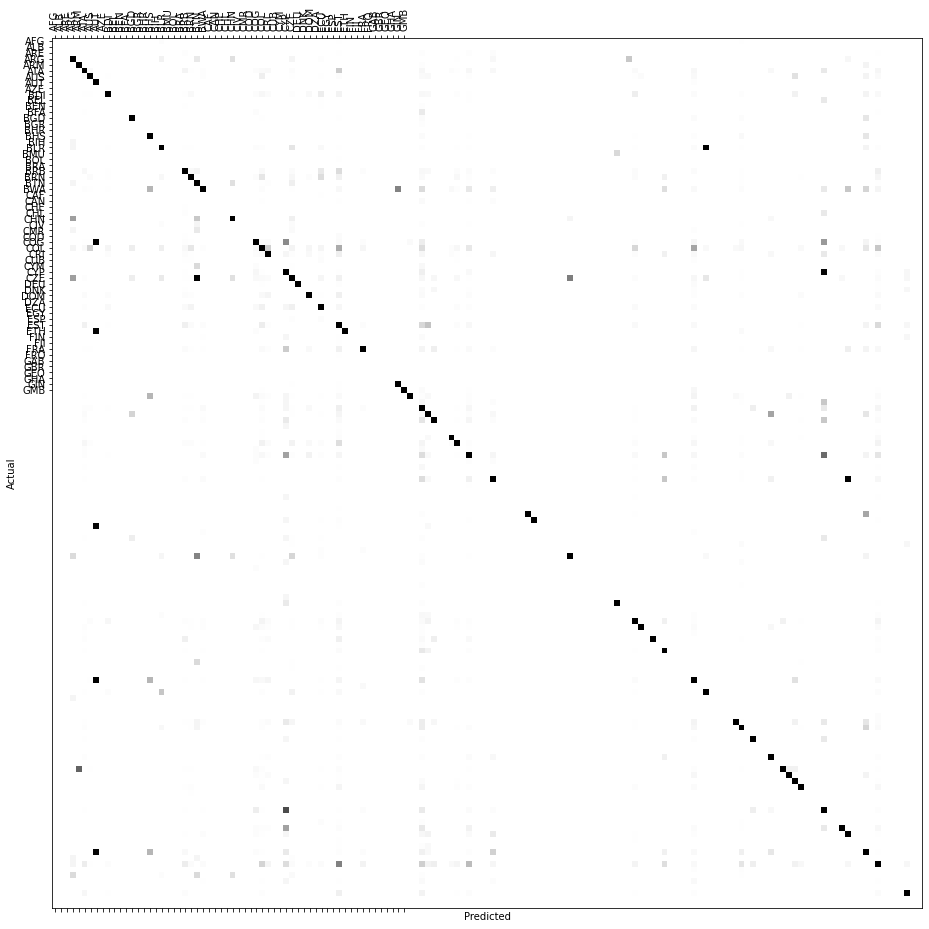

In [18]:
# Create a confusion Matrix. 

def createConfusionMatrix(x_test,y_test,n=1000):
    #see here: https://stackoverflow.com/questions/2148543/how-to-write-a-confusion-matrix-in-python
    # create a label-array and a predicted array:
    ylabelsNumbers = []
    ypredictedNumbers = []
    for i in range(n):
        prediction = model.predict(np.array([x_test[i]]))
        predicted_number = np.argmax(prediction[0])
        ypredictedNumbers.append(predicted_number)
        ylabelNumber = np.argmax(np.array([y_test[i]]))
        ylabelsNumbers.append(ylabelNumber)
    
    y_actu = pd.Series(ylabelsNumbers, name='Actual')
    y_pred = pd.Series(ypredictedNumbers, name='Predicted')
    df_confusion = pd.crosstab(y_actu, y_pred)
    #df_confusion.columns = text_labels
    df_conf_norm = df_confusion / df_confusion.sum(axis=1)
    #df_conf_norm_log = np.log(df_conf_norm)
    #print(df_conf_norm)
    
    fig, ax = plt.subplots(figsize=(16,16))
    ax.matshow(df_conf_norm.clip(0,0.06),cmap='Greys')

    #plt.matshow(df_conf_norm) # imshow
    #plt.colorbar()
    tick_marks = np.arange(len(df_confusion.columns))
    plt.xticks(tick_marks, text_labels, rotation=90)
    plt.yticks(tick_marks, text_labels)
    #plt.tight_layout()    
    plt.ylabel(df_confusion.index.name)
    plt.xlabel(df_confusion.columns.name)
    
    plt.show()
    return df_conf_norm,df_confusion
 
df_conf_norm,df_confusion = createConfusionMatrix(x_test,y_test,n=140000)

In [ ]:
df_confusion.clip(0,10)
df_confusion.columns = text_labels

df_confusion.to_csv("confusion_matrix_new.csv")

In [20]:
print(df_conf_norm)

        0    1    2         3         4         6    7    8    9         10   \
Actual                                                                         
0       NaN  NaN  NaN  0.000000  0.000000  0.000000  0.0  0.0  NaN  0.000000   
1       NaN  NaN  NaN  0.000000  0.000000  0.000000  0.0  0.0  NaN  0.000000   
2       NaN  NaN  NaN  0.000000  0.000000  0.000000  0.0  0.0  NaN  0.000000   
3       NaN  NaN  NaN  0.807512  0.000000  0.000000  0.0  0.0  NaN  0.000000   
4       NaN  NaN  NaN  0.000000  0.897959  0.000000  0.0  0.0  NaN  0.000000   
...     ...  ...  ...       ...       ...       ...  ...  ...  ...       ...   
170     NaN  NaN  NaN  0.000000  0.000000  0.000000  0.0  0.0  NaN  0.000000   
171     NaN  NaN  NaN  0.000000  0.000000  0.000000  0.0  0.0  NaN  0.000000   
172     NaN  NaN  NaN  0.000000  0.000000  0.003941  0.0  0.0  NaN  0.000683   
173     NaN  NaN  NaN  0.000000  0.000000  0.000000  0.0  0.0  NaN  0.000000   
174     NaN  NaN  NaN  0.000000  0.00000

In [ ]:
# using the neural network starts here

In [21]:
null_country=pd.read_csv('N:\\Bibliometric_Germany\\KB data\\processed\\new_2021_Feb\\0_papers_predCountry.csv',encoding=encoding)
null_country.head(50)

,Unnamed: 0,AUTHOR_ID,AFID,PK_INTITUTIONS,PK_ITEMS,PK_AUTHORS,PUBYEAR,SOURCETITLE,DOI,source_id,...,AUTHOR_ID_1,LAST_NAME,FIRST_NAME,INDEXED_NAME,INITIALS,ORCID_ID,INSTITUTION_FULL,POSTALCODE,CITY,COUNTRYCODE
0,115,26643367300,60021110.0,23475834,23475806,23475840,2017.0,"Zeitschrift fur Evidenz, Fortbildung und Quali...",10.1016/j.zefq.2017.11.001,1.130015e+10,...,26643367300,Hasenfuß,NaN,Hasenfuss G.,G.,NaN,Universitätsmedizin Göttingen (UMG)Herzzentrum...,NaN,Göttingen,NaN
1,3796,57214703354,NaN,582229372,582229339,582229408,2017.0,The European respiratory journal,10.1183/13993003.01044-2017,1.845800e+04,...,57214703354,Lange,Berit,Lange B.,B.,NaN,These authors contributed equally,NaN,NaN,NaN
2,6384,56364553200,NaN,1096096605,1096096583,1096096606,2018.0,Nature Reviews Endocrinology,10.1038/s41574-018-0043-z,1.770016e+10,...,56364553200,Morris,Alan,Morris A.,A.,NaN,Nature Reviews Endocrinology,NaN,NaN,NaN
3,6397,56695236700,60008042.0,1097662172,1097662086,1097662183,2018.0,Praxis der Kinderpsychologie und Kinderpsychia...,10.13109/prkk.2018.67.5.442,1.862100e+04,...,56695236700,Dähne,Verena,Dahne V.,V.,NaN,Psychotherapie und Psychosomatik des Kindes-un...,NaN,NaN,NaN
4,6398,36026868400,60008042.0,1097662172,1097662086,1097662195,2018.0,Praxis der Kinderpsychologie und Kinderpsychia...,10.13109/prkk.2018.67.5.442,1.862100e+04,...,36026868400,Sierau,Susan,Sierau S.,S.,NaN,Psychotherapie und Psychosomatik des Kindes-un...,NaN,NaN,NaN
5,6399,25624835200,60008042.0,1097662172,1097662086,1097662188,2018.0,Praxis der Kinderpsychologie und Kinderpsychia...,10.13109/prkk.2018.67.5.442,1.862100e+04,...,25624835200,Klein,Annette M.,Klein A.M.,A.M.,NaN,Psychotherapie und Psychosomatik des Kindes-un...,NaN,NaN,NaN
6,6433,7103207818,107163726.0,1107527141,1107527081,1107527172,2018.0,Shokuhin eiseigaku zasshi. Journal of the Food...,10.3358/shokueishi.59.64,2.075900e+04,...,7103207818,Ozaki,Asako,Ozaki A.,A.,NaN,Osaka Institute of Public Health,NaN,NaN,NaN
7,9803,55867425900,60004692.0,1518487549,1518487531,1518487550,2018.0,Deutsche medizinische Wochenschrift (1946),10.1055/a-0758-2454,1.244500e+04,...,55867425900,Krasselt,Marco,Krasselt M.,M.,NaN,Universitätsklinikum Leipzig AöRNeurologie und...,NaN,NaN,NaN
8,9804,7003454641,60004692.0,1518487549,1518487531,1518487553,2018.0,Deutsche medizinische Wochenschrift (1946),10.1055/a-0758-2454,1.244500e+04,...,7003454641,Baerwald,Christoph,Baerwald C.,C.,NaN,Universitätsklinikum Leipzig AöRNeurologie und...,NaN,NaN,NaN
9,13501,7005765306,123224063.0,2331876701,2331876617,2331876714,2019.0,Wiener Tierarztliche Monatsschrift,NaN,1.957900e+04,...,7005765306,Paulsen,NaN,Paulsen P.,P.,NaN,Institut für Topographische AnatomieDepartment...,NaN,NaN,NaN


In [22]:

# Test the accuracy on other Data:
# generate x_test,y_test from a different file

def get_test_data(fn,encoder,cnState="d_state",encoding = 'utf-8',nrowstoread = 2000, localdropRowIfStateNa=False):
    print("Get_test_data",fn,nrowstoread)
    df = pd.read_csv(fn, usecols=['CITY', 'INSTITUTION_FULL',cnState], encoding=encoding,nrows=nrowstoread) #,'OBSERVATION' #

    
    #print("df: ",df.head())
    if localdropRowIfStateNa:
        print("drop rows without state")
        df = df.replace(to_replace="noInput",value="Na")
        df = df.dropna(subset=[cnState]) # delete row if "Na" in cnState-Column https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.dropna.html

    print("df22: ",df.head())
    df = df.fillna('noInput')
    #merge the input-columns into one big string column 'merged'
    df["merged"] = df["CITY"].map(str) + ' ' + df["INSTITUTION_FULL"] 

    x_train = tokenizer.texts_to_matrix(df['merged'], mode='tfidf')
    print(df.head())
    y_train = encoder.transform(df[cnState])

    print("Get_test_data3",fn,nrowstoread)
    return (x_train,y_train,df,train_tags)


def predictdf(model,xtest,text_labels,dftest, n=2000):
    dftest["predicted"] = "NoIdea"
    dftest["score"] = 0.0
    dftest_rows = dftest.shape[0]
    if n>dftest_rows-1:
        n = dftest_rows-1
    for i in range(n):
        prediction = model.predict(np.array([xtest[i]]))
        predicted_label = text_labels[np.argmax(prediction[0])]   
        dftest.at[i,"predicted"]=predicted_label
        dftest.at[i,"score"]= np.max(prediction[0])
        if i%10000==0:
            print(f"\r predicting... {i}/{n}", end='')

    return dftest

def getTestData_score_predict_save(fn,encoder,model,batch_size=100,cnState= "d_state",encoding = 'utf-8',nrowstoread = 1930, localdropRowIfStateNa=False):

    print("getTestData_score_predict_save 1",fn,nrowstoread)
    xtest, ytest,dftest,train_tags = get_test_data(fn=fn,encoder=encoder,cnState=cnState,encoding=encoding,nrowstoread=nrowstoread,localdropRowIfStateNa=localdropRowIfStateNa)

    score = model.evaluate(xtest, ytest,
                       batch_size=batch_size, verbose=1)
 
    print('Test accuracy on different data:', score[1],fn, nrowstoread)

    print("getTestData_score_predict_save 3",fn,nrowstoread)
    predictdf(model,xtest,text_labels,dftest, n=nrowstoread).to_csv("N:\\Bibliometric_Germany\\KB data\\processed\\new_2021_Feb\\0_predicted.csv")
    print("getTestData_score_predict_save 4",fn,nrowstoread)

In [23]:
#fn = 'null_country.csv'  #"scopus_neuralnetwork_subset.csv"  #"scopus_neuralnetwork_subset_ansi.csv" #"train4-womexico.csv" #"train3.csv" #"filewos_bib_random_nastates.csv"
fn="0_papers_predCountry.csv"
new_path="N:\\Bibliometric_Germany\\KB data\\processed\\new_2021_Feb\\"
print("fn: ",new_path+fn)
getTestData_score_predict_save(new_path+fn,encoder,model,batch_size=100,encoding='utf-8',cnState='COUNTRYCODE',nrowstoread=30000000,localdropRowIfStateNa=False)

fn:  N:\Bibliometric_Germany\KB data\processed\new_2021_Feb\0_papers_predCountry.csv
getTestData_score_predict_save 1 N:\Bibliometric_Germany\KB data\processed\new_2021_Feb\0_papers_predCountry.csv 30000000
Get_test_data N:\Bibliometric_Germany\KB data\processed\new_2021_Feb\0_papers_predCountry.csv 30000000
df22:                                      INSTITUTION_FULL       CITY  COUNTRYCODE
0  Universitätsmedizin Göttingen (UMG)Herzzentrum...  Göttingen          NaN
1                  These authors contributed equally        NaN          NaN
2                       Nature Reviews Endocrinology        NaN          NaN
3  Psychotherapie und Psychosomatik des Kindes-un...        NaN          NaN
4  Psychotherapie und Psychosomatik des Kindes-un...        NaN          NaN
                                    INSTITUTION_FULL       CITY COUNTRYCODE  \
0  Universitätsmedizin Göttingen (UMG)Herzzentrum...  Göttingen     noInput   
1                  These authors contributed equally    noInput

In [27]:
import pandas as pd
encoding = 'utf-8'
predicted_records = pd.read_csv('N:\\Bibliometric_Germany\\KB data\\processed\\new_2021_Feb\\0_predicted.csv',encoding=encoding)

In [28]:
predicted_records

,Unnamed: 0,INSTITUTION_FULL,CITY,COUNTRYCODE,merged,predicted,score
0,0,Universitätsmedizin Göttingen (UMG)Herzzentrum...,Göttingen,noInput,Göttingen Universitätsmedizin Göttingen (UMG)H...,DEU,1.000000
1,1,These authors contributed equally,noInput,noInput,noInput These authors contributed equally,DEU,0.647117
2,2,Nature Reviews Endocrinology,noInput,noInput,noInput Nature Reviews Endocrinology,DEU,0.278856
3,3,Psychotherapie und Psychosomatik des Kindes-un...,noInput,noInput,noInput Psychotherapie und Psychosomatik des K...,DEU,1.000000
4,4,Psychotherapie und Psychosomatik des Kindes-un...,noInput,noInput,noInput Psychotherapie und Psychosomatik des K...,DEU,1.000000
...,...,...,...,...,...,...,...
143984,143984,Kantonsspital LuzernInst. F. Anasthesiologie R...,noInput,noInput,noInput Kantonsspital LuzernInst. F. Anasthesi...,CHE,1.000000
143985,143985,Kantonsspital LuzernInst. F. Anasthesiologie R...,noInput,noInput,noInput Kantonsspital LuzernInst. F. Anasthesi...,CHE,1.000000
143986,143986,Urologische Klinik und Poliklinik,noInput,noInput,noInput Urologische Klinik und Poliklinik,DEU,0.999884
143987,143987,Urologische Klinik und Poliklinik,noInput,noInput,noInput Urologische Klinik und Poliklinik,DEU,0.999884


In [29]:
country_score=predicted_records[["predicted","score"]]
country_score

,predicted,score
0,DEU,1.000000
1,DEU,0.647117
2,DEU,0.278856
3,DEU,1.000000
4,DEU,1.000000
...,...,...
143984,CHE,1.000000
143985,CHE,1.000000
143986,DEU,0.999884
143987,DEU,0.999884


In [30]:
null_country

,Unnamed: 0,AUTHOR_ID,AFID,PK_INTITUTIONS,PK_ITEMS,PK_AUTHORS,PUBYEAR,SOURCETITLE,DOI,source_id,...,AUTHOR_ID_1,LAST_NAME,FIRST_NAME,INDEXED_NAME,INITIALS,ORCID_ID,INSTITUTION_FULL,POSTALCODE,CITY,COUNTRYCODE
0,115,26643367300,60021110.0,23475834,23475806,23475840,2017.0,"Zeitschrift fur Evidenz, Fortbildung und Quali...",10.1016/j.zefq.2017.11.001,1.130015e+10,...,26643367300,Hasenfuß,NaN,Hasenfuss G.,G.,NaN,Universitätsmedizin Göttingen (UMG)Herzzentrum...,NaN,Göttingen,NaN
1,3796,57214703354,NaN,582229372,582229339,582229408,2017.0,The European respiratory journal,10.1183/13993003.01044-2017,1.845800e+04,...,57214703354,Lange,Berit,Lange B.,B.,NaN,These authors contributed equally,NaN,NaN,NaN
2,6384,56364553200,NaN,1096096605,1096096583,1096096606,2018.0,Nature Reviews Endocrinology,10.1038/s41574-018-0043-z,1.770016e+10,...,56364553200,Morris,Alan,Morris A.,A.,NaN,Nature Reviews Endocrinology,NaN,NaN,NaN
3,6397,56695236700,60008042.0,1097662172,1097662086,1097662183,2018.0,Praxis der Kinderpsychologie und Kinderpsychia...,10.13109/prkk.2018.67.5.442,1.862100e+04,...,56695236700,Dähne,Verena,Dahne V.,V.,NaN,Psychotherapie und Psychosomatik des Kindes-un...,NaN,NaN,NaN
4,6398,36026868400,60008042.0,1097662172,1097662086,1097662195,2018.0,Praxis der Kinderpsychologie und Kinderpsychia...,10.13109/prkk.2018.67.5.442,1.862100e+04,...,36026868400,Sierau,Susan,Sierau S.,S.,NaN,Psychotherapie und Psychosomatik des Kindes-un...,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143984,27618719,6603149706,60033223.0,35217858318,35217858272,35217858329,1996.0,Praxis,NaN,1.850016e+10,...,6603149706,Fieber,NaN,Fieber T.,T.,NaN,Kantonsspital LuzernInst. F. Anasthesiologie R...,NaN,NaN,NaN
143985,27618720,7003776509,60033223.0,35217858318,35217858272,35217858326,1996.0,Praxis,NaN,1.850016e+10,...,7003776509,Schupfer,NaN,Schupfer G.,G.,NaN,Kantonsspital LuzernInst. F. Anasthesiologie R...,NaN,NaN,NaN
143986,27618724,7003591689,105636939.0,35218382345,35218382307,35218382352,1996.0,Aktuelle Urologie,NaN,9.490500e+04,...,7003591689,Siemer,NaN,Siemer S.W.,S.W.,NaN,Urologische Klinik und Poliklinik,NaN,NaN,NaN
143987,27618725,7202530471,105636939.0,35218382345,35218382307,35218382359,1996.0,Aktuelle Urologie,NaN,9.490500e+04,...,7202530471,Ziegler,NaN,Ziegler M.,M.,NaN,Urologische Klinik und Poliklinik,NaN,NaN,NaN


In [31]:
predicted_country_reliable=null_country.join(country_score)
predicted_country_reliable=predicted_country_reliable[predicted_country_reliable["score"]>0.8]
predicted_country_reliable=predicted_country_reliable.drop(columns=["COUNTRYCODE"])
predicted_country_reliable=predicted_country_reliable.rename(columns={"predicted": "COUNTRYCODE"})
predicted_country_reliable

,Unnamed: 0,AUTHOR_ID,AFID,PK_INTITUTIONS,PK_ITEMS,PK_AUTHORS,PUBYEAR,SOURCETITLE,DOI,source_id,...,LAST_NAME,FIRST_NAME,INDEXED_NAME,INITIALS,ORCID_ID,INSTITUTION_FULL,POSTALCODE,CITY,COUNTRYCODE,score
0,115,26643367300,60021110.0,23475834,23475806,23475840,2017.0,"Zeitschrift fur Evidenz, Fortbildung und Quali...",10.1016/j.zefq.2017.11.001,1.130015e+10,...,Hasenfuß,NaN,Hasenfuss G.,G.,NaN,Universitätsmedizin Göttingen (UMG)Herzzentrum...,NaN,Göttingen,DEU,1.000000
3,6397,56695236700,60008042.0,1097662172,1097662086,1097662183,2018.0,Praxis der Kinderpsychologie und Kinderpsychia...,10.13109/prkk.2018.67.5.442,1.862100e+04,...,Dähne,Verena,Dahne V.,V.,NaN,Psychotherapie und Psychosomatik des Kindes-un...,NaN,NaN,DEU,1.000000
4,6398,36026868400,60008042.0,1097662172,1097662086,1097662195,2018.0,Praxis der Kinderpsychologie und Kinderpsychia...,10.13109/prkk.2018.67.5.442,1.862100e+04,...,Sierau,Susan,Sierau S.,S.,NaN,Psychotherapie und Psychosomatik des Kindes-un...,NaN,NaN,DEU,1.000000
5,6399,25624835200,60008042.0,1097662172,1097662086,1097662188,2018.0,Praxis der Kinderpsychologie und Kinderpsychia...,10.13109/prkk.2018.67.5.442,1.862100e+04,...,Klein,Annette M.,Klein A.M.,A.M.,NaN,Psychotherapie und Psychosomatik des Kindes-un...,NaN,NaN,DEU,1.000000
6,6433,7103207818,107163726.0,1107527141,1107527081,1107527172,2018.0,Shokuhin eiseigaku zasshi. Journal of the Food...,10.3358/shokueishi.59.64,2.075900e+04,...,Ozaki,Asako,Ozaki A.,A.,NaN,Osaka Institute of Public Health,NaN,NaN,JPN,0.999974
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143983,27618718,7006550584,60033223.0,35217858318,35217858272,35217858322,1996.0,Praxis,NaN,1.850016e+10,...,Konrad,NaN,Konrad Ch.,Ch.,NaN,Kantonsspital LuzernInst. F. Anasthesiologie R...,NaN,NaN,CHE,1.000000
143984,27618719,6603149706,60033223.0,35217858318,35217858272,35217858329,1996.0,Praxis,NaN,1.850016e+10,...,Fieber,NaN,Fieber T.,T.,NaN,Kantonsspital LuzernInst. F. Anasthesiologie R...,NaN,NaN,CHE,1.000000
143985,27618720,7003776509,60033223.0,35217858318,35217858272,35217858326,1996.0,Praxis,NaN,1.850016e+10,...,Schupfer,NaN,Schupfer G.,G.,NaN,Kantonsspital LuzernInst. F. Anasthesiologie R...,NaN,NaN,CHE,1.000000
143986,27618724,7003591689,105636939.0,35218382345,35218382307,35218382352,1996.0,Aktuelle Urologie,NaN,9.490500e+04,...,Siemer,NaN,Siemer S.W.,S.W.,NaN,Urologische Klinik und Poliklinik,NaN,NaN,DEU,0.999884


In [33]:
# Save as csv

import csv

predicted_country_reliable.to_csv('N:\\Bibliometric_Germany\\KB data\\processed\\new_2021_Feb\\0_predicted_reliable.csv', index = False)
papers_predCountry.drop(columns={'Unnamed: 0','score'},inplace=True)

papers=pd.concat([papers_Country,papers_predCountry])